# Step 1.1: EDA

## Objective

In this step we run a simple Exploratory Data Analysis to understand the data and identify any issues we might run into during training

## Findings

The dataset has 856610 records, 16 features and no duplicate records. Most features are categorical with a limited number of unique values, so we will have to include an Enconding step in the training pipeline. We also have a datetime feature that might have to be broken down during the feature engineering stage. Some features have null values, which we will have to deal with during training. 

Since a search is considered successful if the outcome is positive, and is related to the search, the feature of interest has to be calculated by combining the **Outcome** and **Outcome linked to object of search** features.

We also found that the following stations can't be used for training, since they have a very high number of missing values for **"Outcome linked to object of search"**:

* humberside
* lancashire
* metropolitan
* west-midlands
* leicestershire (even though the missing ratio is a bit lower, the number of true outcomes is so low that this station should be disregarded)

In regards to Correlation, we didn't find strong correlations between any of the features, besides **Officer-defined ethnicity** and **Self-defined ethnicity**. But, if we remove the White ethnicity records, this correlation drops quite significantly, which could lead to the conclusion that the data is skewed towards that particular set.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

## Define Aux Functions

In [2]:
def show_unique_value_graph(df, column):
    # This functions is used to plot a bar graph with the number of unique values for a specific feature
    # If the number of unique values is higher than 10 it displays value counts instead

    print("The list of unique values in '" + column + "' is :" + str(list(df[column].unique())))

    if(len(df[column].unique()) < 10):
        df[column].value_counts(dropna=False).plot.barh()
        plt.title("Distinct values count for " + column);
    else:
        display(df[column].value_counts(dropna=False))

## Load the data

In [3]:
df_ = pd.read_csv("data/train.csv")
df_.head(10)

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire
5,769ac39b-cfe7-4587-855f-b574cdd46933,Person search,2020-12-01T10:30:00+00:00,NaN,50.808359,-1.079465,Male,18-24,Mixed/Multiple ethnic groups - White and Black...,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,False,False,hampshire
6,2f3c1b3b-b41a-4b12-b1ab-3c34f93cd20a,Person search,2020-12-01T10:50:00+00:00,NaN,50.914047,-1.401123,Male,over 34,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
7,b3f957b8-b942-4789-b47c-aa1a6dfcabe7,Person search,2020-12-01T11:00:00+00:00,NaN,50.915304,-1.398959,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
8,79807773-d027-4cdf-ad41-531b3bb2cbab,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,18-24,Black/African/Caribbean/Black British - Caribbean,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,False,False,hampshire
9,fa5f250a-08f0-411d-85ff-eeaab9659cb5,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire


## Data Description

In [4]:
df_.describe()

,Latitude,Longitude
count,700308.000000,700308.000000
mean,51.925536,-0.665373
std,0.907127,1.122665
min,49.892149,-8.069623
25%,51.468408,-1.238443
50%,51.535937,-0.169241
75%,52.083248,-0.042936
max,57.479900,1.757268


In [5]:
print("The dataset has " + str(len(df_)) + " records.")
print("The dataset has " + str(len(df_.columns)) + " features.")
print("The dataset has " + str(df_["observation_id"].nunique()) + " unique observation_ids.")

The dataset has 856610 records.
The dataset has 16 features.
The dataset has 856610 unique observation_ids.


In [6]:
df_.dtypes

observation_id                               object
Type                                         object
Date                                         object
Part of a policing operation                 object
Latitude                                    float64
Longitude                                   float64
Gender                                       object
Age range                                    object
Self-defined ethnicity                       object
Officer-defined ethnicity                    object
Legislation                                  object
Object of search                             object
Outcome                                      object
Outcome linked to object of search           object
Removal of more than just outer clothing     object
station                                      object
dtype: object

## Lat and Lon feature Analysis

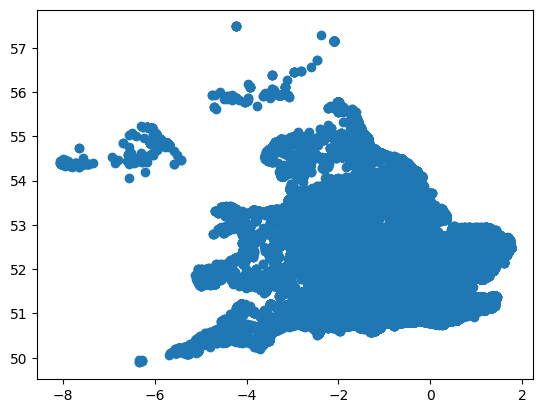

In [6]:
plt.scatter(x=df_["Longitude"],y=df_["Latitude"])

# coordinates are in WGS - 84

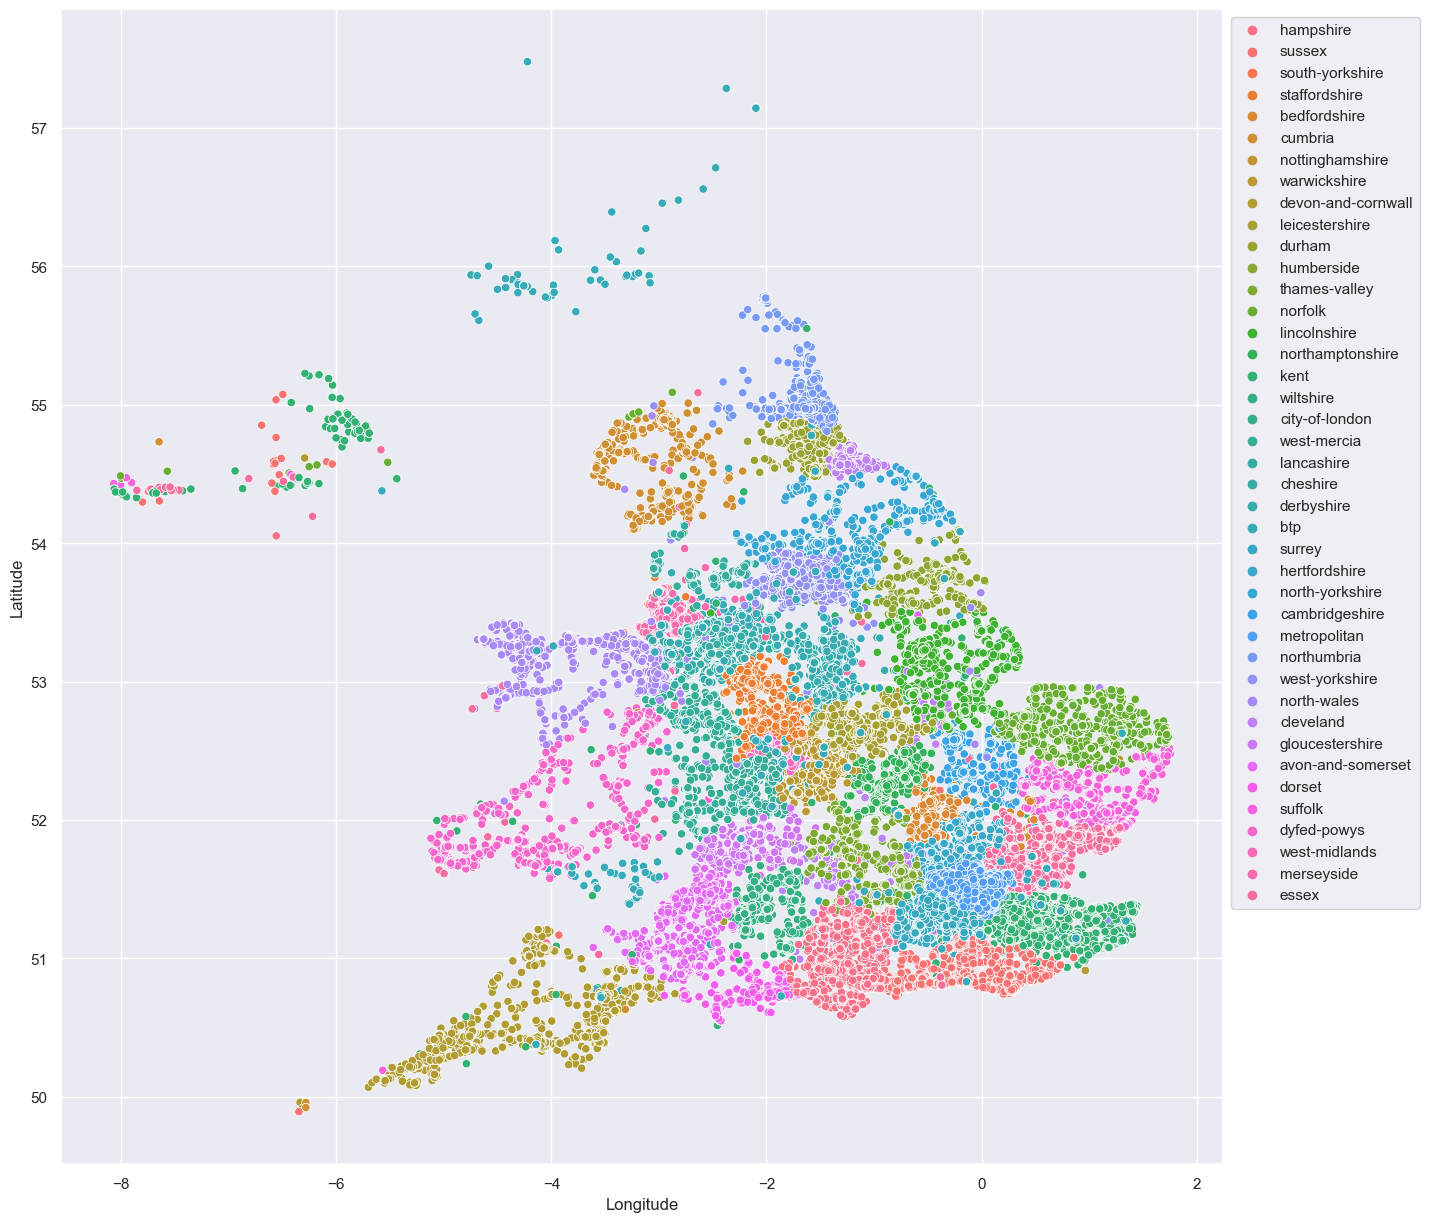

In [11]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(data= df_, x="Longitude",y="Latitude", hue="station")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Categorical Feature Analysis

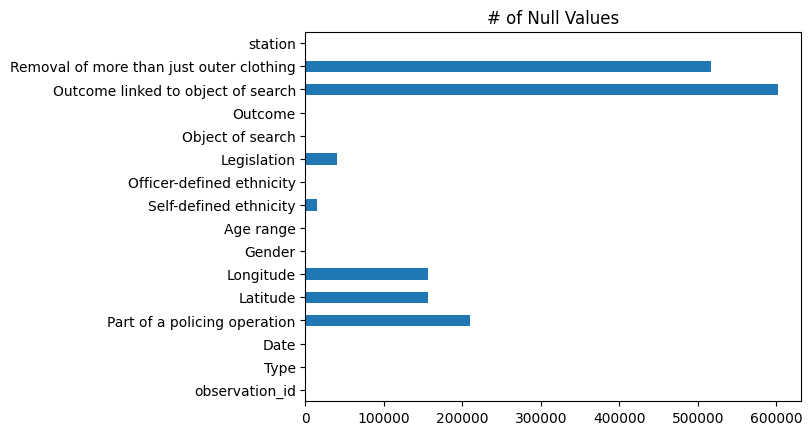

In [7]:
df_.isna().sum().plot.barh()
plt.title("# of Null Values");

The list of unique values in 'Type' is :['Person search', 'Person and Vehicle search', 'Vehicle search']


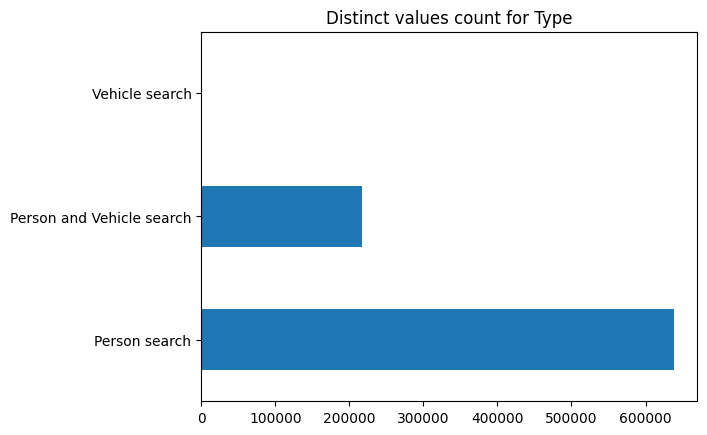

In [8]:
show_unique_value_graph(df_, "Type")

For Vehicle searches, Removal of clothing should be set to NaN

The list of unique values in 'Part of a policing operation' is :[nan, False, True]


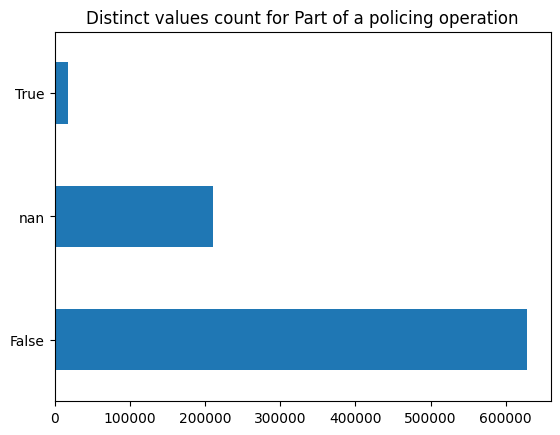

In [9]:
show_unique_value_graph(df_, "Part of a policing operation")

The list of unique values in 'Gender' is :['Male', 'Female', 'Other']


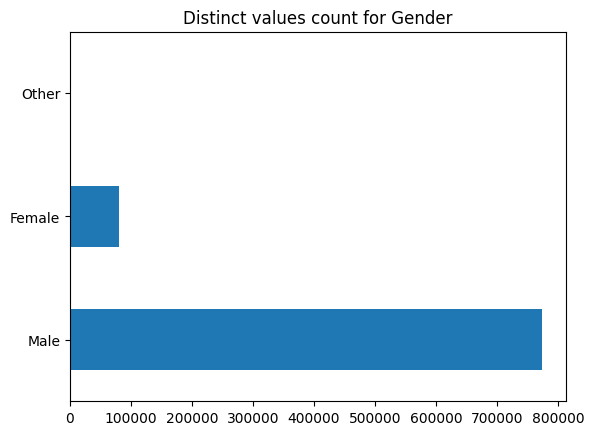

In [10]:
show_unique_value_graph(df_, "Gender")

The list of unique values in 'Age range' is :['25-34', 'over 34', '10-17', '18-24', 'under 10']


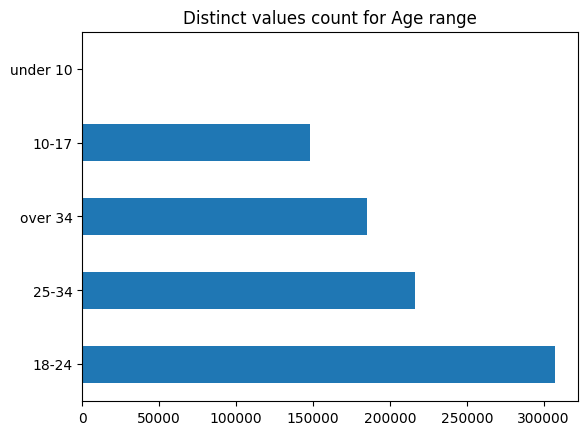

In [11]:
show_unique_value_graph(df_, "Age range")

### Race-Gender-Age Tuple Analysis

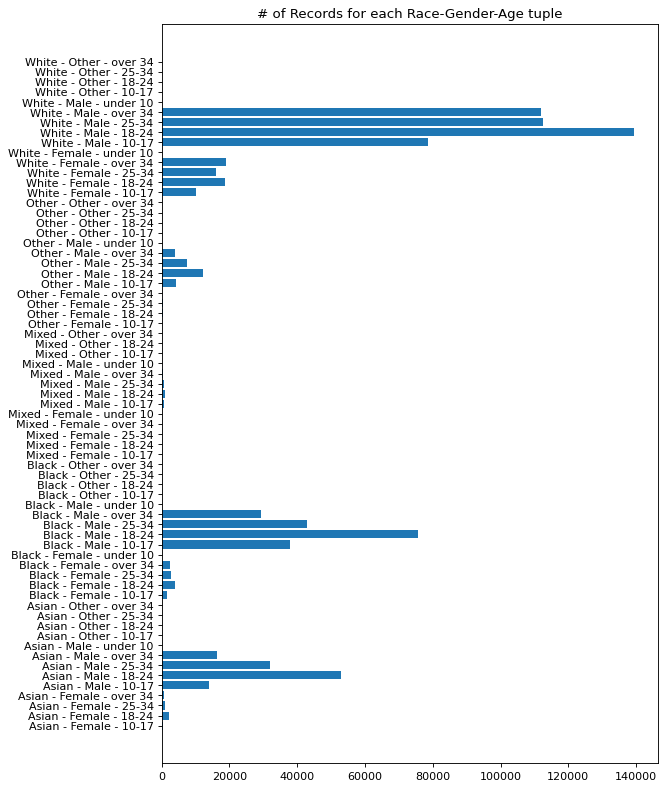

In [12]:
df_sensitive_classes = df_.copy()

df_sensitive_classes["sensitive_class"] = (df_sensitive_classes["Officer-defined ethnicity"] + " - "
                                           + df_sensitive_classes["Gender"] + " - "
                                           + df_sensitive_classes["Age range"])

sensitive_class_dist = df_sensitive_classes["sensitive_class"].value_counts(dropna=False).sort_index()

plt.figure(figsize=(8, 12), dpi=80)

plt.barh(sensitive_class_dist.index, sensitive_class_dist)
plt.title("# of Records for each Race-Gender-Age tuple");

In [13]:
show_unique_value_graph(df_, "Self-defined ethnicity")

The list of unique values in 'Self-defined ethnicity' is :['Other ethnic group - Not stated', 'White - Any other White background', 'White - English/Welsh/Scottish/Northern Irish/British', 'Mixed/Multiple ethnic groups - White and Black African', 'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background', 'Black/African/Caribbean/Black British - Caribbean', 'Asian/Asian British - Any other Asian background', 'Asian/Asian British - Indian', 'Asian/Asian British - Bangladeshi', 'Black/African/Caribbean/Black British - African', 'White - Irish', 'Other ethnic group - Any other ethnic group', 'Mixed/Multiple ethnic groups - White and Asian', 'Asian/Asian British - Chinese', 'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background', 'Mixed/Multiple ethnic groups - White and Black Caribbean', 'Asian/Asian British - Pakistani', 'White - Gypsy or Irish Traveller', nan, 'Other ethnic group - Arab']


White - English/Welsh/Scottish/Northern Irish/British                                   353095
Other ethnic group - Not stated                                                         136650
White - Any other White background                                                       74405
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background     62216
Black/African/Caribbean/Black British - African                                          43750
Asian/Asian British - Any other Asian background                                         40676
Black/African/Caribbean/Black British - Caribbean                                        28864
Asian/Asian British - Pakistani                                                          23903
Asian/Asian British - Bangladeshi                                                        16808
Other ethnic group - Any other ethnic group                                              15203
NaN                                               

The list of unique values in 'Officer-defined ethnicity' is :['White', 'Other', 'Asian', 'Black', 'Mixed']


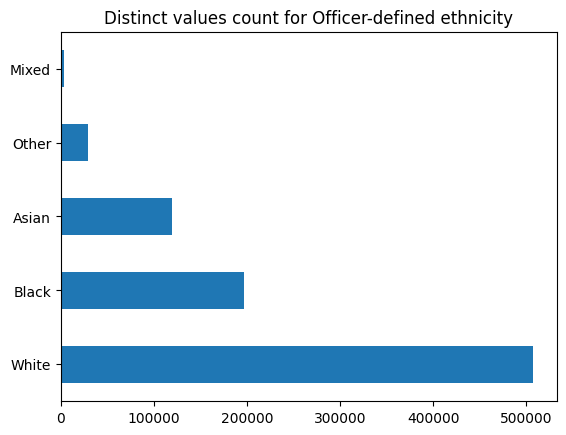

In [14]:
show_unique_value_graph(df_, "Officer-defined ethnicity")

In [15]:
show_unique_value_graph(df_, "Legislation")

The list of unique values in 'Legislation' is :['Police and Criminal Evidence Act 1984 (section 1)', 'Misuse of Drugs Act 1971 (section 23)', 'Firearms Act 1968 (section 47)', 'Poaching Prevention Act 1862 (section 2)', 'Psychoactive Substances Act 2016 (s36(2))', 'Criminal Justice and Public Order Act 1994 (section 60)', 'Criminal Justice Act 1988 (section 139B)', nan, 'Psychoactive Substances Act 2016 (s37(2))', 'Wildlife and Countryside Act 1981 (section 19)', 'Aviation Security Act 1982 (section 27(1))', 'Public Stores Act 1875 (section 6)', 'Hunting Act 2004 (section 8)', 'Environmental Protection Act 1990 (section 34B )', 'Customs and Excise Management Act 1979 (section 163)', 'Police and Criminal Evidence Act 1984 (section 6)', 'Conservation of Seals Act 1970 (section 4)', 'Crossbows Act 1987 (section 4)', 'Deer Act 1991 (section 12)', 'Protection of Badgers Act 1992 (section 11)']


Misuse of Drugs Act 1971 (section 23)                      546936
Police and Criminal Evidence Act 1984 (section 1)          254859
NaN                                                         39747
Criminal Justice and Public Order Act 1994 (section 60)      8711
Firearms Act 1968 (section 47)                               4610
Criminal Justice Act 1988 (section 139B)                      549
Psychoactive Substances Act 2016 (s36(2))                     547
Poaching Prevention Act 1862 (section 2)                      408
Police and Criminal Evidence Act 1984 (section 6)              92
Wildlife and Countryside Act 1981 (section 19)                 39
Environmental Protection Act 1990 (section 34B )               25
Deer Act 1991 (section 12)                                     17
Aviation Security Act 1982 (section 27(1))                     17
Customs and Excise Management Act 1979 (section 163)           16
Hunting Act 2004 (section 8)                                   12
Crossbows 

In [16]:
show_unique_value_graph(df_, "Object of search")

The list of unique values in 'Object of search' is :['Article for use in theft', 'Controlled drugs', 'Stolen goods', 'Offensive weapons', 'Anything to threaten or harm anyone', 'Articles for use in criminal damage', 'Firearms', 'Game or poaching equipment', 'Psychoactive substances', 'Fireworks', 'Evidence of offences under the Act', 'Goods on which duty has not been paid etc.', 'Detailed object of search unavailable', 'Crossbows', 'Evidence of wildlife offences', 'Evidence of hunting any wild mammal with a dog', 'Seals or hunting equipment']


Controlled drugs                                  558100
Offensive weapons                                 112652
Stolen goods                                       75698
Article for use in theft                           38706
Evidence of offences under the Act                 23080
Articles for use in criminal damage                16696
Anything to threaten or harm anyone                15535
Firearms                                            5420
Fireworks                                           5072
Psychoactive substances                             4805
Game or poaching equipment                           321
Detailed object of search unavailable                309
Goods on which duty has not been paid etc.            97
Crossbows                                             54
Evidence of wildlife offences                         46
Evidence of hunting any wild mammal with a dog        12
Seals or hunting equipment                             7
Name: Object of search, dtype: 

The list of unique values in 'Outcome' is :['Community resolution', 'A no further action disposal', 'Arrest', 'Summons / charged by post', 'Caution (simple or conditional)', 'Penalty Notice for Disorder', 'Khat or Cannabis warning']


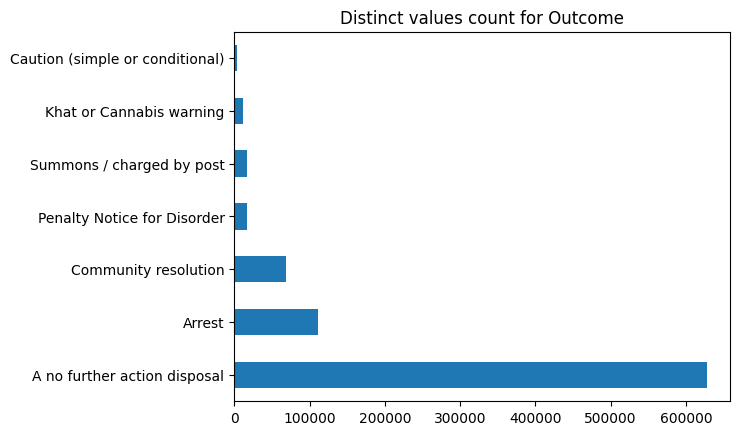

In [17]:
show_unique_value_graph(df_, "Outcome")

### Notes on Outcomes
- **Community resolution**: Community resolutions are frequently used by police to deal with low-level offending. If you accept a community resolution, you are not prosecuted and therefore not required to attend court. ([from this page](https://www.bindmans.com/knowledge-hub/blogs/what-are-community-resolutions/))
- **A no further action disposal**
- **Arrest**
- **Summons / charged by post**
- **Caution (simple or conditional)**: A police caution is a formal alternative to prosecution in minor cases, administered by the police in England and Wales. It is commonly used to resolve cases where full prosecution is not seen as the most appropriate solution.[1] Accepting a caution requires an admission of guilt. ([from wikipedia](https://en.wikipedia.org/wiki/Police_caution))
- **Penalty Notice for Disorder**
- **Khat or Cannabis warning**

The list of unique values in 'Outcome linked to object of search' is :[False, True, nan]


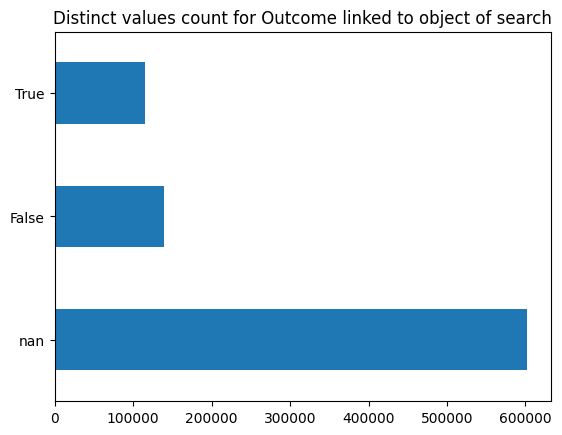

In [18]:
show_unique_value_graph(df_, "Outcome linked to object of search")

The list of unique values in 'Removal of more than just outer clothing' is :[False, True, nan]


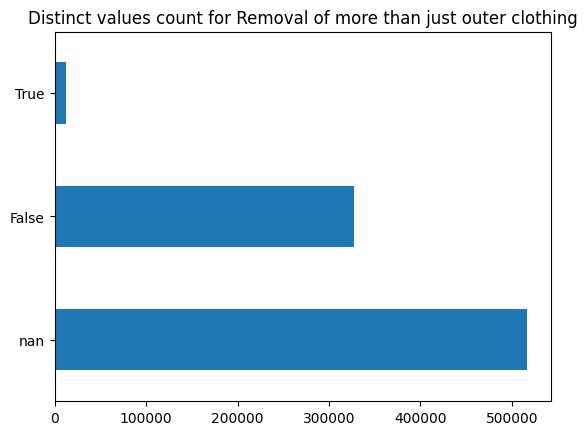

In [19]:
show_unique_value_graph(df_, "Removal of more than just outer clothing")

In [20]:
show_unique_value_graph(df_, "station")

The list of unique values in 'station' is :['hampshire', 'sussex', 'south-yorkshire', 'staffordshire', 'bedfordshire', 'cumbria', 'nottinghamshire', 'warwickshire', 'devon-and-cornwall', 'leicestershire', 'durham', 'humberside', 'thames-valley', 'norfolk', 'lincolnshire', 'northamptonshire', 'kent', 'wiltshire', 'city-of-london', 'west-mercia', 'lancashire', 'cheshire', 'derbyshire', 'btp', 'surrey', 'hertfordshire', 'north-yorkshire', 'cambridgeshire', 'metropolitan', 'northumbria', 'west-yorkshire', 'north-wales', 'cleveland', 'gloucestershire', 'avon-and-somerset', 'dorset', 'suffolk', 'dyfed-powys', 'west-midlands', 'merseyside', 'essex']


metropolitan          436867
merseyside             38563
thames-valley          31437
west-yorkshire         25321
south-yorkshire        24300
hampshire              20230
btp                    18557
kent                   17875
lancashire             15254
hertfordshire          13971
avon-and-somerset      13189
essex                  12889
sussex                 11378
devon-and-cornwall     10906
surrey                 10774
humberside             10306
west-midlands           9271
west-mercia             9262
staffordshire           9039
norfolk                 8766
leicestershire          8298
cheshire                8271
northumbria             8034
cleveland               7907
nottinghamshire         7523
north-wales             7044
suffolk                 6482
bedfordshire            5904
lincolnshire            5030
dyfed-powys             4851
city-of-london          4539
northamptonshire        4427
warwickshire            3923
durham                  3585
north-yorkshir

## Check Stations without Outcome linked to object of search values

In [24]:
stations = list(df_["station"].unique())

values_check = {}
for station in stations:
    total_records = len(df_.loc[df_["station"]==station,"Outcome linked to object of search"])
    outcome_nans = df_.loc[df_["station"]==station,"Outcome linked to object of search"].isna().sum()
    outcome_trues = len(df_.loc[(df_["station"]==station) & (df_["Outcome linked to object of search"]),"Outcome linked to object of search"])
    clothes_nans = df_.loc[df_["station"]==station,"Removal of more than just outer clothing"].isna().sum()
    outcome_ratio = outcome_nans / total_records
    clothes_ratio = clothes_nans / total_records

    values = {'total_records':total_records, 'outcome_nans':outcome_nans, 'outcome_trues':outcome_trues, 'clothes_nans':clothes_nans, 'missing_outcome_ratio':outcome_ratio,  'missing_clothes_ratio':clothes_ratio}

    values_check[station] = values

df_missing = pd.DataFrame(values_check).transpose()

df_missing.loc[(df_missing["missing_outcome_ratio"] > 0.90) | (df_missing["missing_clothes_ratio"] > 0.90), :].sort_values(by="missing_outcome_ratio", ascending=False)


,total_records,outcome_nans,outcome_trues,clothes_nans,missing_outcome_ratio,missing_clothes_ratio
humberside,10306.0,10306.0,0.0,0.0,1.000000,0.000000
lancashire,15254.0,15254.0,0.0,15254.0,1.000000,1.000000
metropolitan,436867.0,436867.0,0.0,436867.0,1.000000,1.000000
west-midlands,9271.0,9108.0,123.0,20.0,0.982418,0.002157
leicestershire,8298.0,7551.0,5.0,0.0,0.909978,0.000000
cleveland,7907.0,6237.0,1301.0,7907.0,0.788795,1.000000
north-yorkshire,3563.0,2588.0,757.0,3563.0,0.726354,1.000000
surrey,10774.0,50.0,2899.0,10774.0,0.004641,1.000000
south-yorkshire,24300.0,0.0,2820.0,23955.0,0.000000,0.985802


With the above results we can establish that the following stations can't be used for training, since they have a very high number of missing values for **"Outcome linked to object of search"**:

* humberside
* lancashire
* metropolitan
* west-midlands
* leicestershire (even though the missing ratio is a bit lower, the number of true outcomes is so low that this station should be disregarded)

The following station can't be used for analysis clothes removal requests since the number of missing values in this feature is extremely high:
* lancashire
* metropolitan
* cleveland
* yorkshire
* surrey
* south-yorkshire

The missing values for the remaining stations will be filled with FALSE

## Date Column

In [51]:
# dropping observation_id seen as it doesn't add any relevant information

df_cat = df_.copy().drop(columns='observation_id')

# dropping stations with 0 or very low Outcome linked to object of search values

df_cat = df_cat.loc[~df_cat["station"].isin(["humberside", "lancashire", "metropolitan", "west-midlands", "leicestershire"])]

# df_cat = df_cat.loc[~df_cat["station"].isin(['metropolitan', 'humberside', 'leicestershire']),:].copy()

display(df_cat["station"].value_counts())

merseyside            38563
thames-valley         31437
west-yorkshire        25321
south-yorkshire       24300
hampshire             20230
btp                   18557
kent                  17875
hertfordshire         13971
avon-and-somerset     13189
essex                 12889
sussex                11378
devon-and-cornwall    10906
surrey                10774
west-mercia            9262
staffordshire          9039
norfolk                8766
cheshire               8271
northumbria            8034
cleveland              7907
nottinghamshire        7523
north-wales            7044
suffolk                6482
bedfordshire           5904
lincolnshire           5030
dyfed-powys            4851
city-of-london         4539
northamptonshire       4427
warwickshire           3923
durham                 3585
north-yorkshire        3563
gloucestershire        3542
derbyshire             3419
cambridgeshire         3367
cumbria                3022
wiltshire              2867
dorset              

In [52]:
df_cat["Date"] = pd.to_datetime(df_cat["Date"], infer_datetime_format=True, dayfirst=False)

## Dealing with Categorical Features

In [53]:
df_cat.columns

Index(['Type', 'Date', 'Part of a policing operation', 'Latitude', 'Longitude',
       'Gender', 'Age range', 'Self-defined ethnicity',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')

In [54]:
cat_columns = ['Type', 'Gender', 'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'station']

In [55]:
for col in cat_columns:
    df_cat[col] = df_cat[col].astype('category').cat.as_unordered()

### Ordinal Columns

In [56]:
cat_columns = ['Age range']

df_cat['Age range'] = df_cat['Age range'].astype('category').cat.as_ordered().cat.reorder_categories(['under 10', '10-17', '18-24', '25-34', 'over 34'], ordered=True)

df_cat['Age range']

0           25-34
1         over 34
2         over 34
3           10-17
4           10-17
           ...   
856605      18-24
856606      25-34
856607      18-24
856608      25-34
856609      18-24
Name: Age range, Length: 376614, dtype: category
Categories (5, object): ['under 10' < '10-17' < '18-24' < '25-34' < 'over 34']

### Boolean Columns

In [57]:
bool_columns = ['Part of a policing operation','Outcome linked to object of search','Removal of more than just outer clothing']

In [58]:
for col in bool_columns:
    df_cat[col] = df_cat[col].astype('boolean')

In [59]:
df_cat.dtypes

Type                                                   category
Date                                        datetime64[ns, UTC]
Part of a policing operation                            boolean
Latitude                                                float64
Longitude                                               float64
Gender                                                 category
Age range                                              category
Self-defined ethnicity                                 category
Officer-defined ethnicity                              category
Legislation                                            category
Object of search                                       category
Outcome                                                category
Outcome linked to object of search                      boolean
Removal of more than just outer clothing                boolean
station                                                category
dtype: object

### Note on Categories

In [60]:
# cat.codes will return the categorical series coded

df_cat["Gender"].cat.codes.unique()

array([1, 0, 2], dtype=int8)

In [61]:
# cat.categories will return the categories in the same order that they were coded (1st one will be 0 and so on)

display(df_cat["Age range"][0])

display(df_cat["Age range"].cat.codes[0])

display(df_cat["Age range"].cat.categories)

'25-34'

3

Index(['under 10', '10-17', '18-24', '25-34', 'over 34'], dtype='object')

In [62]:
# nan values will get coded to -1

df_cat["Self-defined ethnicity"].cat.codes.unique()

array([14, 15, 16, 10,  6,  7,  0,  3,  1,  5, 18, 12,  9,  2,  8, 11,  4,
       17, -1, 13], dtype=int8)

## Adding the Target Feature

From Q&A:

A search is considered successful if the outcome is positive, and is related to the search. 

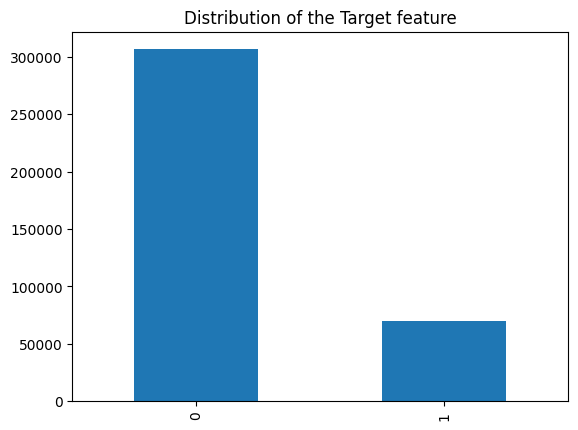

In [63]:
df_cat['target'] = 0
df_cat.loc[(df_cat["Outcome"]!='A no further action disposal') & (df_cat['Outcome linked to object of search']==True), 'target'] = 1

df_cat['target'].value_counts(dropna=False).plot.bar()
plt.title("Distribution of the Target feature")
plt.show();

## Check how success rate changes through time

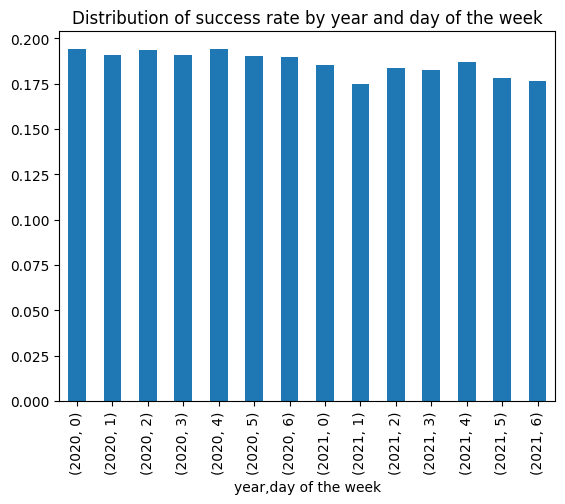

In [64]:
date_check = df_cat.copy()
date_check['quarter'] = date_check['Date'].dt.quarter
date_check['year'] = date_check['Date'].dt.year
date_check['hour'] = date_check['Date'].dt.hour
date_check['day of the week'] = date_check['Date'].dt.weekday
date_group = date_check.groupby(['year','day of the week'])["target"].agg(['size', np.sum])
date_group['rate'] = date_group['sum'] / date_group['size']
date_group["rate"].plot.bar()
plt.title("Distribution of success rate by year and day of the week")
plt.show();

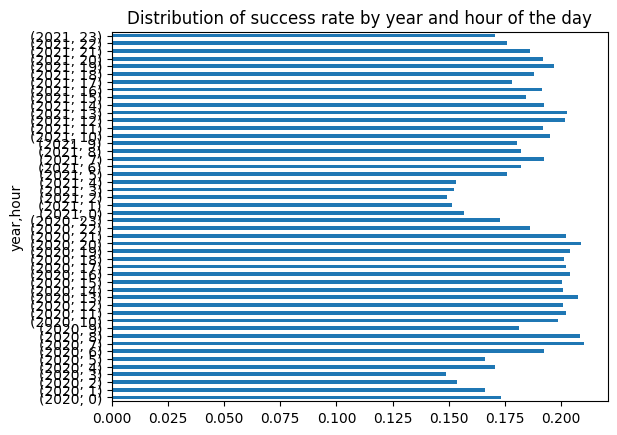

In [65]:
date_check = df_cat.copy()
date_check['quarter'] = date_check['Date'].dt.quarter
date_check['year'] = date_check['Date'].dt.year
date_check['hour'] = date_check['Date'].dt.hour
date_check['day of the week'] = date_check['Date'].dt.weekday
date_group = date_check.groupby(['year','hour'])["target"].agg(['size', np.sum])
date_group['rate'] = date_group['sum'] / date_group['size']
date_group["rate"].plot.barh()
plt.title("Distribution of success rate by year and hour of the day")
plt.show();

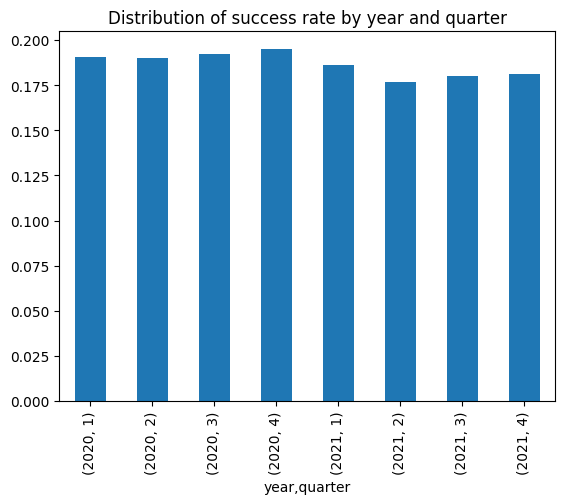

In [66]:
date_check = df_cat.copy()
date_check['quarter'] = date_check['Date'].dt.quarter
date_check['year'] = date_check['Date'].dt.year
date_check['hour'] = date_check['Date'].dt.hour
date_check['day of the week'] = date_check['Date'].dt.weekday
date_group = date_check.groupby(['year','quarter'])["target"].agg(['size', np.sum])
date_group['rate'] = date_group['sum'] / date_group['size']
date_group["rate"].plot.bar()
plt.title("Distribution of success rate by year and quarter")
plt.show();

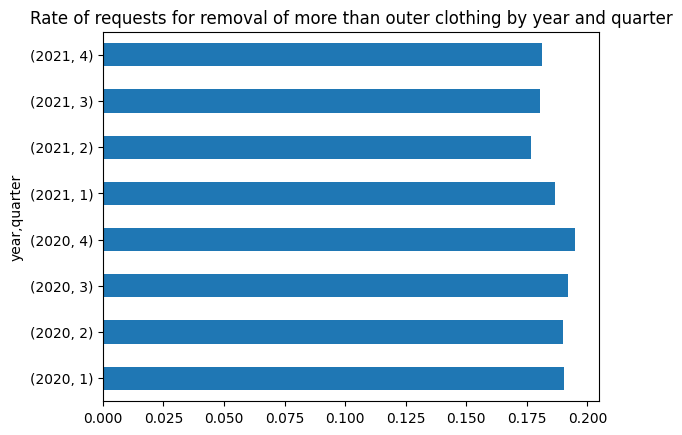

In [67]:
clothes_check = df_cat.copy()
clothes_check['quarter'] = clothes_check['Date'].dt.quarter
clothes_check['year'] = clothes_check['Date'].dt.year
clothes_group = clothes_check.groupby(['year', 'quarter'])["target"].agg(['size', np.sum])
clothes_group['rate'] = clothes_group['sum'] / clothes_group['size']
clothes_group["rate"].plot.barh()
plt.title("Rate of requests for removal of more than outer clothing by year and quarter")
plt.show();

## Encode Categorical Features

In [68]:
df_encoded = df_cat.copy()

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'category':
        df_encoded[col] = df_encoded[col].cat.codes
    elif df_encoded[col].dtype == 'boolean':
        # df_encoded[col] = df_encoded[col].replace({True: 1, False: 0})
        df_encoded[col] = df_encoded[col] * 1.0 # hacky way to convert booleans to Floats

df_encoded = pd.DataFrame(df_encoded.to_dict())
display(df_encoded)


,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target
0,1,2020-12-01 01:10:00+00:00,<NA>,50.798824,-1.089471,1,3,14,4,12,1,3,0.0,0.0,15,0
1,1,2020-12-01 02:00:00+00:00,<NA>,50.785099,-1.091540,1,4,15,3,10,3,0,0.0,0.0,15,0
2,1,2020-12-01 09:15:00+00:00,<NA>,50.952006,-1.403341,1,4,16,4,10,3,0,0.0,1.0,15,0
3,1,2020-12-01 10:20:00+00:00,<NA>,50.806383,-1.079844,1,1,14,4,12,16,0,0.0,0.0,15,0
4,1,2020-12-01 10:24:00+00:00,<NA>,50.806670,-1.081982,1,1,14,0,12,13,0,0.0,0.0,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856605,0,2020-04-30 15:10:00+00:00,<NA>,54.965502,-1.604609,1,2,15,4,10,3,0,1.0,0.0,24,0
856606,0,2020-04-30 15:10:00+00:00,<NA>,54.965502,-1.604609,1,3,15,3,10,3,0,1.0,1.0,24,0
856607,0,2020-04-30 17:00:00+00:00,<NA>,54.966266,-1.453704,1,2,16,4,10,3,4,1.0,0.0,24,1
856608,1,2020-04-30 17:35:00+00:00,<NA>,54.971596,-1.636589,1,3,16,4,10,3,1,1.0,0.0,24,1


In [69]:
df_encoded.dtypes

Type                                                      int64
Date                                        datetime64[ns, UTC]
Part of a policing operation                             object
Latitude                                                float64
Longitude                                               float64
Gender                                                    int64
Age range                                                 int64
Self-defined ethnicity                                    int64
Officer-defined ethnicity                                 int64
Legislation                                               int64
Object of search                                          int64
Outcome                                                   int64
Outcome linked to object of search                       object
Removal of more than just outer clothing                 object
station                                                   int64
target                                  

In [70]:
df_encoded["target"]

0         0
1         0
2         0
3         0
4         0
         ..
856605    0
856606    0
856607    1
856608    1
856609    1
Name: target, Length: 376614, dtype: int64

## Analyze Distribution

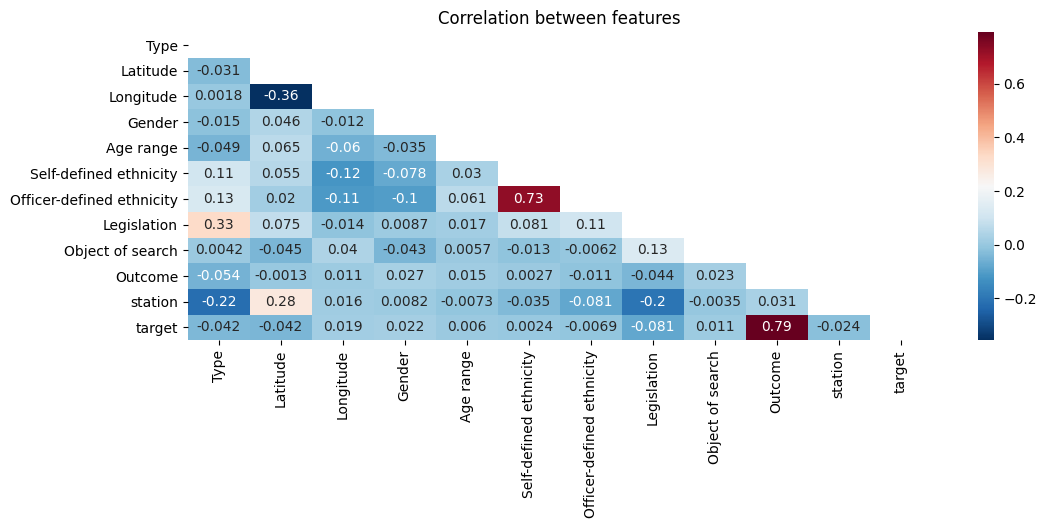

In [71]:
# only works for numerical variables
corr_matrix = df_encoded.corr(method='spearman')
corr_matrix

# mask to get only the lower triangle
lower_triangle_mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
cor_mat_lower = corr_matrix.mask(lower_triangle_mask)

plt.figure(figsize = (12,4)) # <-- just sets the figure size 
plt.title("Correlation between features")

sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); #

Looking at the correlation matrix above it seems like the correlation between Officer-defined ethnicity and Self-defined ethnicity is high. 

After further inspection, it seems like this is simply due to the fact that most observations have Officer-defined ethnicity as white. 

If we remove observations where Officer-defined ethnicity is white, the correlation between these two features drops significantly (see cell below).

In [95]:
# cat.categories will return the categories in the same order that they were coded (1st one will be 0 and so on)

display(df_cat["Officer-defined ethnicity"].cat.categories)


mask = (df_encoded["Officer-defined ethnicity"]!=4)

df_encoded.loc[mask, "Officer-defined ethnicity"].corr(df_encoded.loc[mask, "Self-defined ethnicity"])

Index(['Asian', 'Black', 'Mixed', 'Other', 'White'], dtype='object')

0.3223799585196581

In [44]:
# since some features have a very high variance, plotting this is not ideal to get a true understanding of the data

df_encoded.var().sort_values()

/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_15407/1314880532.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_encoded.var().sort_values()


Removal of more than just outer clothing      0.035670
Part of a policing operation                  0.080310
Gender                                        0.103269
target                                        0.139603
Type                                          0.185202
Outcome linked to object of search            0.247861
Age range                                     1.083636
Latitude                                      1.357683
Outcome                                       1.840741
Longitude                                     1.938254
Officer-defined ethnicity                     1.990597
Legislation                                  12.724776
Object of search                             21.259892
Self-defined ethnicity                       24.800039
station                                     126.741808
dtype: float64

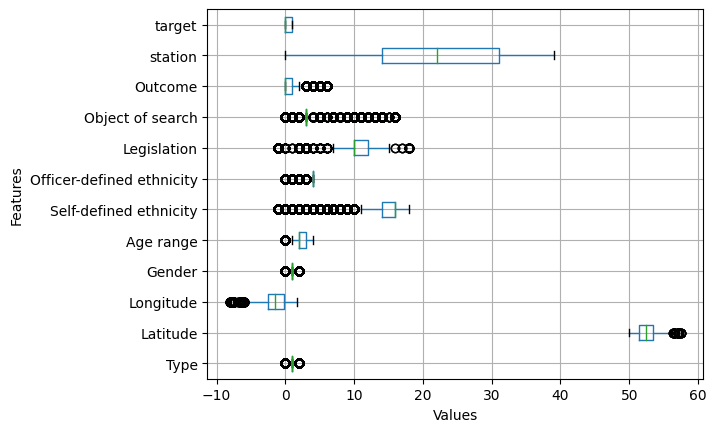

In [41]:
df_encoded.boxplot(vert=False);
plt.xlabel("Values");
plt.ylabel("Features");

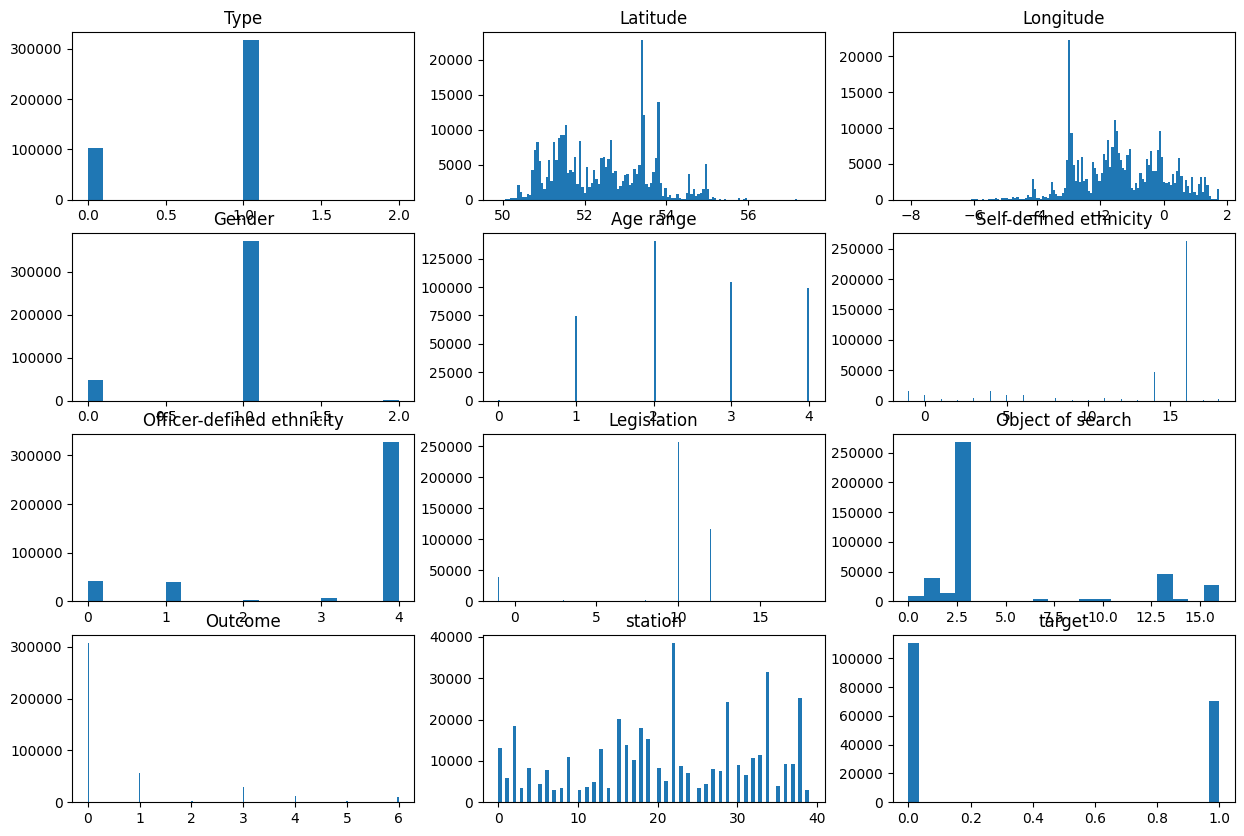

In [43]:
# plots histograms for all numeric variables

max_rows = round((df_encoded._get_numeric_data().shape[1]+1)/3)
total_graphs = df_encoded._get_numeric_data().shape[1]+1
plt.figure(figsize=(15,10)) # figsize adjusts the size of the grid

for graph_num in range(1, total_graphs):
    plt.subplot(max_rows, 3, graph_num) # syntax is: plt.subplot(nrows, ncols, index)
    # code for generating the first chart goes here
    plt.hist(df_encoded._get_numeric_data()[df_encoded._get_numeric_data().columns[graph_num-1]], bins="auto")
    plt.title(df_encoded._get_numeric_data().columns[graph_num-1])
plt.show()

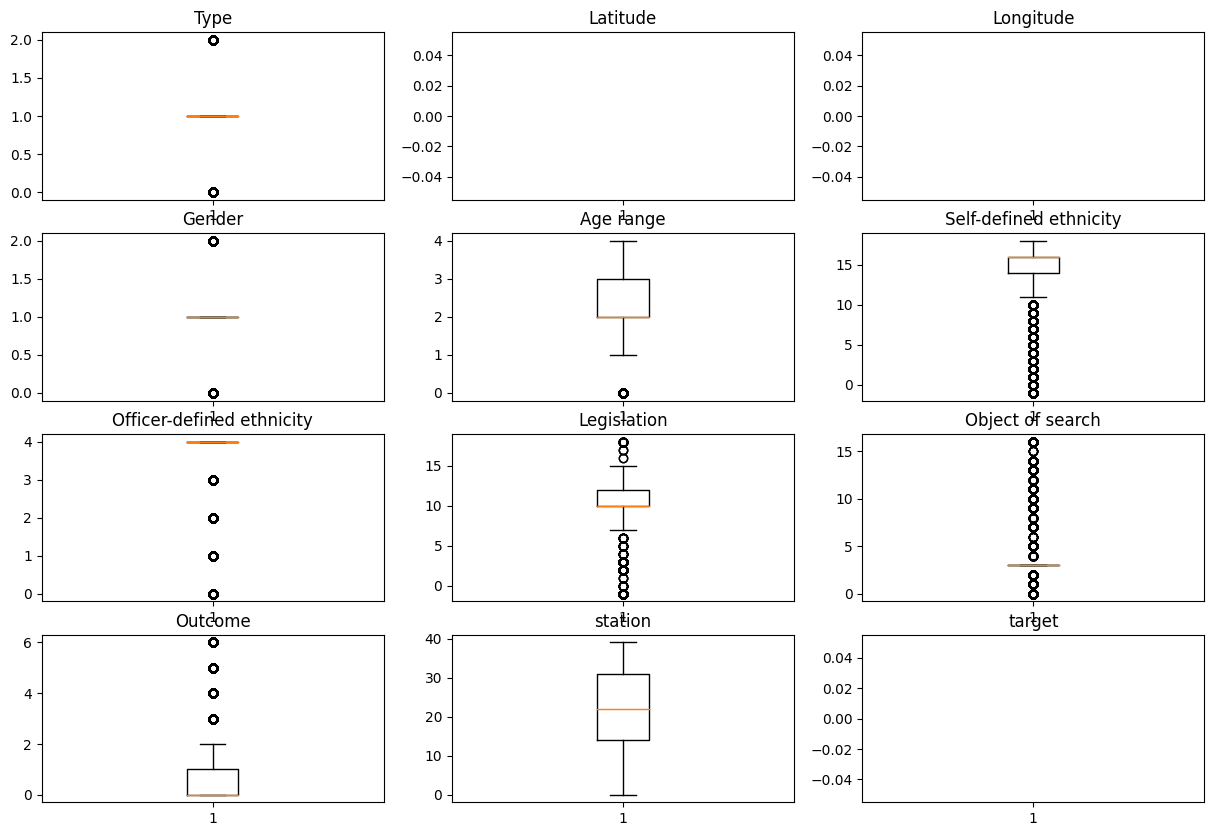

In [44]:
# plot boxplots for all numeric variables


max_rows = round((df_encoded._get_numeric_data().shape[1]+1)/3)
total_graphs = df_encoded._get_numeric_data().shape[1]+1
plt.figure(figsize=(15,10)) # figsize adjusts the size of the grid

for graph_num in range(1, total_graphs):
    plt.subplot(max_rows, 3, graph_num) # syntax is: plt.subplot(nrows, ncols, index)
    # code for generating the first chart goes here
    plt.boxplot(df_encoded._get_numeric_data()[df_encoded._get_numeric_data().columns[graph_num-1]])
    plt.title(df_encoded._get_numeric_data().columns[graph_num-1])
plt.show()

/Users/joaosa/projects/.venv/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


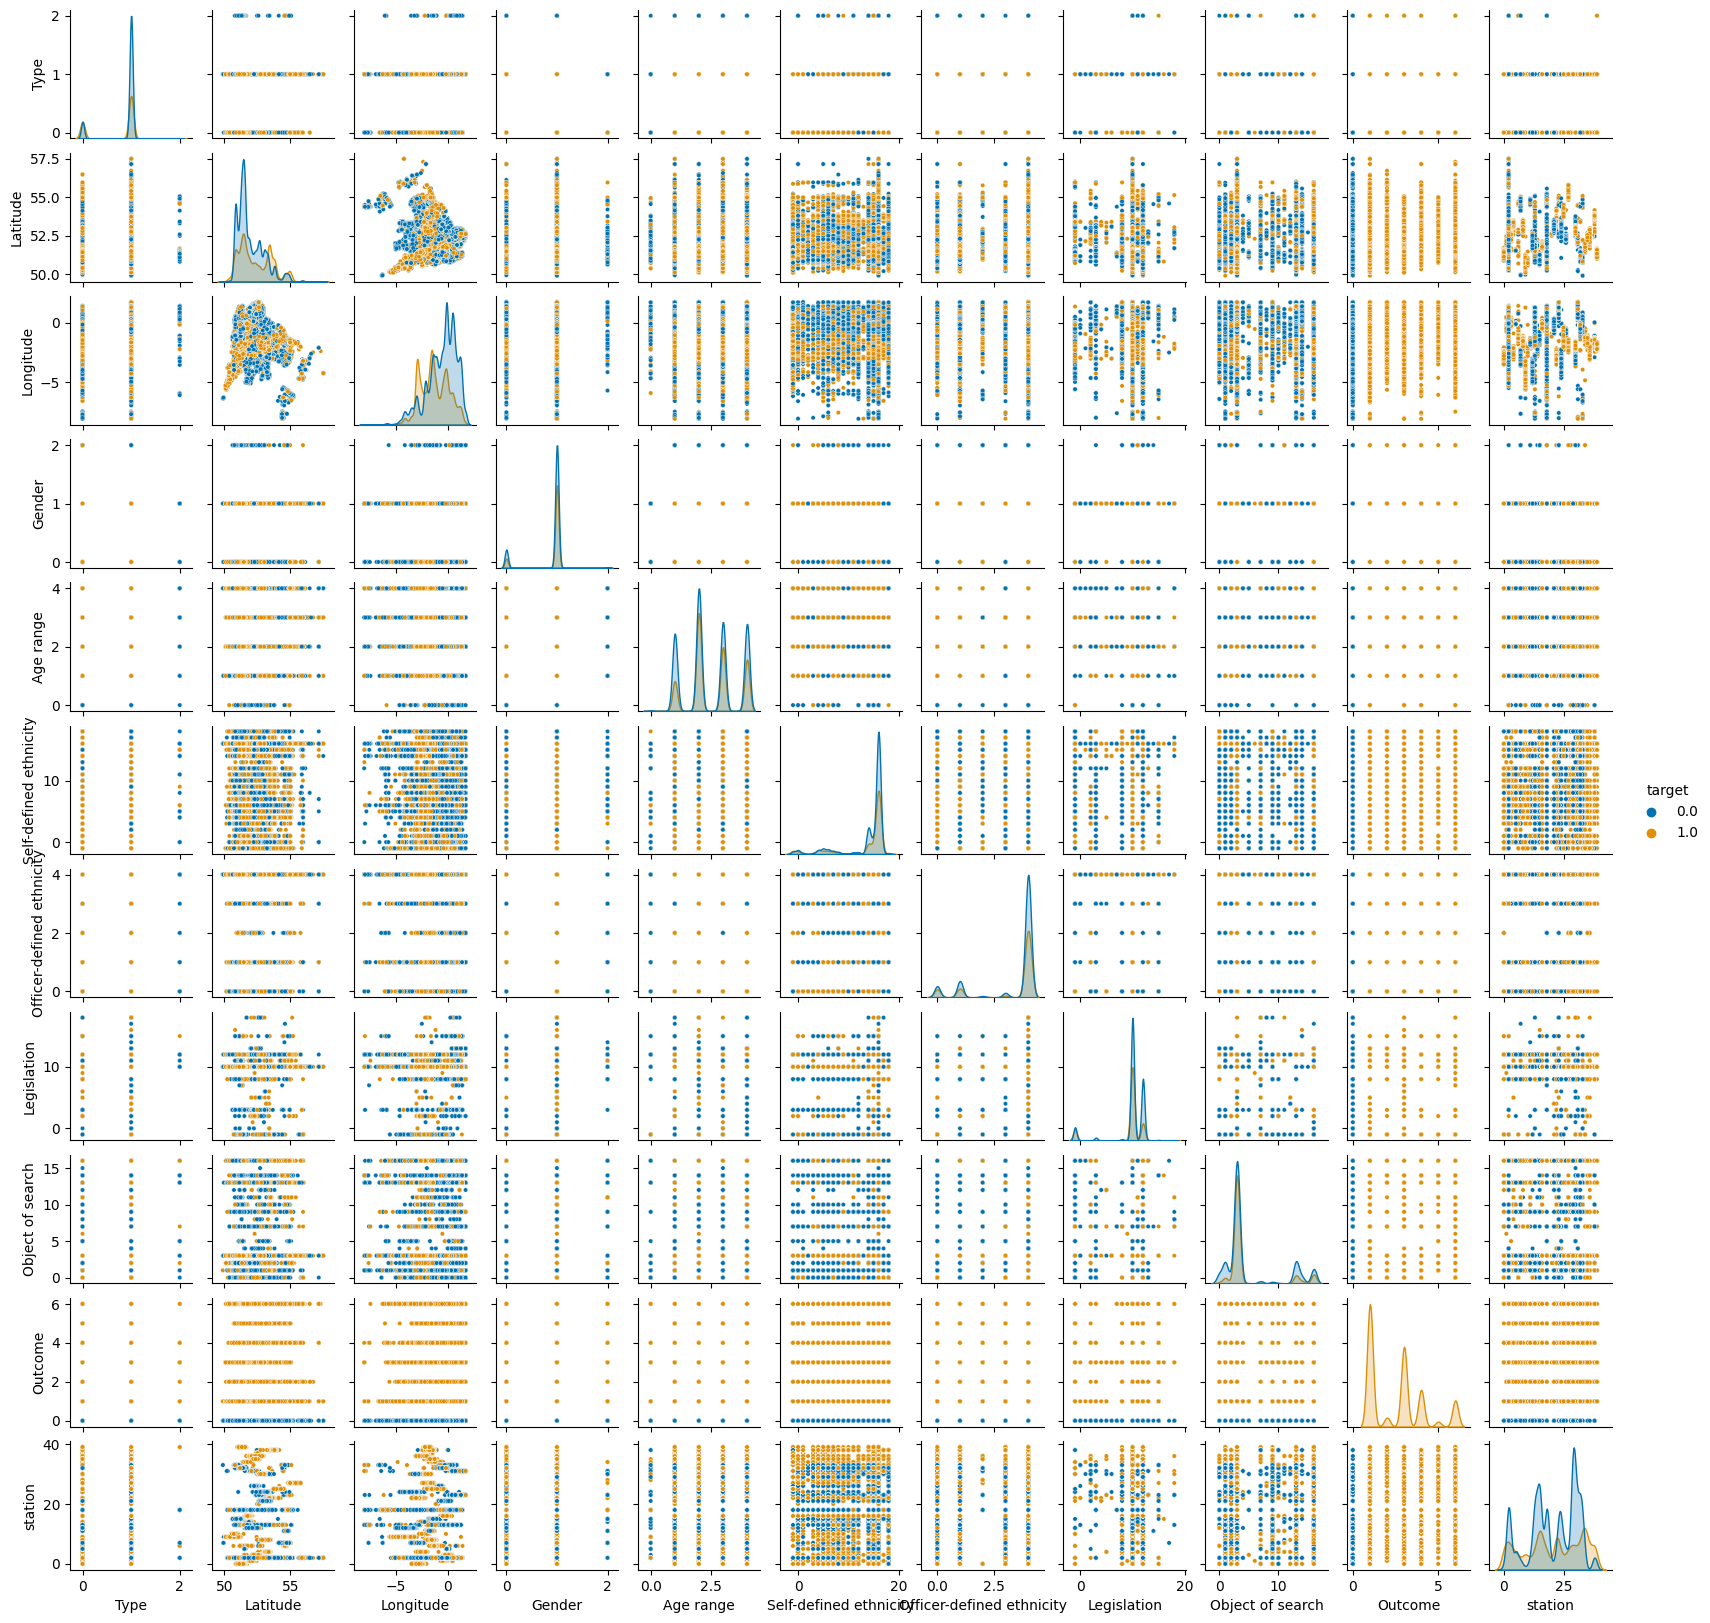

In [45]:
temp = df_encoded._get_numeric_data() # to hack an error 
sns.pairplot(temp,hue='target',palette='colorblind',
             height=1.5,plot_kws={"s": 10});